In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
sns.set_style("darkgrid")

# Exploratory Data Analysis

In [2]:
# Load training set
dataset = pd.read_csv('./input/train.csv', index_col = 'PassengerId')
target = 'Survived'
features = [c for c in list(dataset.columns.values) if c != target]

# size of the dataset
print('Dataset = {:d} observations x {:d} features (including target)'.format(dataset.shape[0], dataset.shape[1]))
# list of features
dataset.sample(5)

Dataset = 891 observations x 11 features (including target)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
574,1,3,"Kelly, Miss. Mary",female,NaN,0,0,14312,7.7500,NaN,Q
607,0,3,"Karaic, Mr. Milan",male,30.0,0,0,349246,7.8958,NaN,S
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S
803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S


In [3]:
summary = pd.DataFrame(np.array([dataset.dtypes, 
                                 dataset.isnull().sum(), 
                                 dataset.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                       
                       columns=np.array(list(dataset)))
display(summary)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Dtype,int64,int64,object,object,float64,int64,int64,object,float64,object,object
NbrNullValues,0,0,0,0,177,0,0,0,0,687,2
NbrDistinctVal,2,3,891,2,88,7,7,681,248,147,3


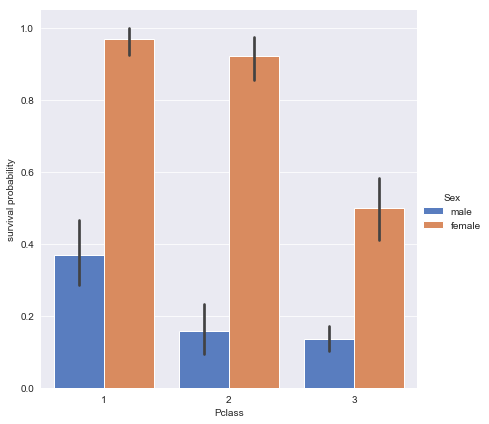

In [4]:
# visualization of interactions btw survival and sex/class 
g = sns.catplot(x='Pclass', y=target, hue='Sex', data=dataset, height=6, kind='bar', palette='muted');
g.despine(left=True)
g.set_ylabels("survival probability")

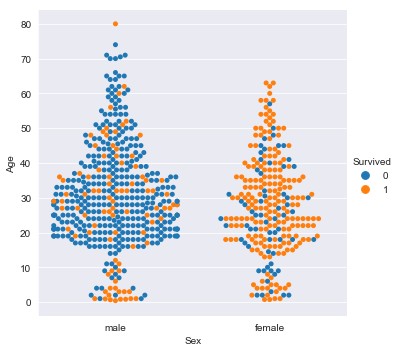

In [5]:
sns.catplot(x='Sex', y='Age', hue='Survived', data=dataset, kind='swarm');

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(dataset[features], dataset[[target]], test_size=0.25)
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
79,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
883,3,"Dahlberg, Miss. Gerda Ulrika",female,22.00,0,0,7552,10.5167,NaN,S
98,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C
604,3,"Torber, Mr. Ernst William",male,44.00,0,0,364511,8.0500,NaN,S


In [7]:
ct = ColumnTransformer( transformers = 
                       [('tr_sex', make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), 
                                                 OneHotEncoder(handle_unknown='ignore')), ['Sex', 'Pclass']),
                        ('tr_age', make_pipeline(SimpleImputer(), StandardScaler()), ['Age', 'Fare'])],                       
                      remainder='drop', sparse_threshold=0)
tmp = ct.fit_transform(X_train)
print(tmp.shape)

(668, 7)


In [8]:
model = make_pipeline(
    ct,
    LogisticRegression())

In [9]:
model.fit(X_train, y_train)
score = model.score(X_valid, y_valid['Survived'])
print('logistic regression score: {:.4f}'.format(score))

logistic regression score: 0.8296


C:\Users\CEDRIC\Anaconda3\envs\datascience\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\CEDRIC\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
